# T001 · Compound data acquisition (ChEMBL)

Authors:

- Svetlana Leng, CADD seminar 2017, Volkamer lab, Charité/FU Berlin 
- Paula Junge, CADD seminar 2018, Volkamer lab, Charité/FU Berlin
- Dominique Sydow, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)
- Andrea Volkamer, 2020, [Volkamer lab, Charité](https://volkamerlab.org/)
- Yonghui Chen, 2020, [Volkamer lab, Charité](https://volkamerlab.org/)

__Talktorial T001__: This talktorial is part of the TeachOpenCADD pipeline described in the [first TeachOpenCADD paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x), comprising of talktorials T001-T010.

## Aim of this talktorial

In this notebook, we will learn more about the ChEMBL database and how to extract data from ChEMBL, i.e. (compound, activity data) pairs for a target of interest. These data sets can be used for many cheminformatics tasks, such as similarity search, clustering or machine learning.

Our work here will include finding compounds which were tested against a certain target and filtering available bioactivity data.

### Contents in *Theory*

* ChEMBL database
    * ChEMBL web services
    * ChEMBL webresource client
* Compound activity measures
    * IC50 measure
    * pIC50 value

### Contents in *Practical*
    
**Goal: Get a list of compounds with bioactivity data for a given target**

* Connect to ChEMBL database
* Get target data (example: EGFR kinase)
    * Fetch and download target data
    * Select target ChEMBL ID
* Get bioactivity data
    * Fetch and download bioactivity data for target
    * Preprocess and filter bioactivity data
* Get compound data
    * Fetch and download compound data
    * Preprocess and filter compound data
* Output bioactivity-compound data
    * Merge bioactivity and compound data, and add pIC50 values
    * Draw molecules with highest pIC50
    * Freeze bioactivity data to ChEMBL 27
    * Write output file

### References

* ChEMBL bioactivity database: [Gaulton *et al.*, <i>Nucleic Acids Res.</i> (2017), 45(Database issue), D945–D954](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5210557/)
* ChEMBL web services: [Davies *et al.*, <i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881) 
* [ChEMBL web-interface](https://www.ebi.ac.uk/chembl/)
*  GitHub [ChEMBL webrescource client](https://github.com/chembl/chembl_webresource_client)
* The EBI RDF platform: [Jupp *et al.*, <i>Bioinformatics </i> (2014), 30(9), 1338-9](https://www.ncbi.nlm.nih.gov/pubmed/24413672)
* Info on half maximal inhibitory concentration: [(p)IC50](https://en.wikipedia.org/wiki/IC50)
* [UniProt website](https://www.uniprot.org/)

## Theory

### ChEMBL database
>"ChEMBL is a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity and genomic data to aid the translation of genomic information into effective new drugs." ([ChEMBL website](https://www.ebi.ac.uk/chembl/))

* Open large-scale bioactivity database
* **Current data content (as of 09.2020, ChEMBL 27):**
    * \>1.9 million distinct compounds
    * \>16 million activity values
    * Assays are mapped to ~13,000 targets
* **Data sources** include scientific literature, PubChem bioassays, Drugs for Neglected Diseases Initiative (DNDi), BindingDB database, ...
* ChEMBL data can be accessed via a [web-interface](https://www.ebi.ac.uk/chembl/), the [EBI-RDF platform](https://www.ncbi.nlm.nih.gov/pubmed/24413672) and the [ChEMBL webrescource client](https://github.com/chembl/chembl_webresource_client)

#### ChEMBL web services

* RESTful web service
* ChEMBL web service version 2.x resource schema: 

![ChEMBL web service schema](images/chembl_webservices_schema_diagram.jpg)

*Figure 1:* 
"[ChEMBL web service schema diagram](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489243/figure/F2/). The oval shapes represent ChEMBL web service resources and the line between two resources indicates that they share a common attribute. The arrow direction shows where the primary information about a resource type can be found. A dashed line indicates the relationship between two resources behaves differently. For example, the `Image` resource provides a graphical based representation of a `Molecule`."
Figure and description taken from: [<i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881).

#### ChEMBL webresource client

* Python client library for accessing ChEMBL data
* Handles interaction with the HTTPS protocol
* Lazy evaluation of results -> reduced number of network requests

### Compound activity measures

#### IC50 measure

* [Half maximal inhibitory concentration](https://en.wikipedia.org/wiki/IC50)
* Indicates how much of a particular drug or other substance is needed to inhibit a given biological process by half

![Wiki_Example_IC50_curve_demonstrating_visually_how_IC50_is_derived](images/Wiki_Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png)

*Figure 2:* Visual demonstration of how to derive an IC50 value: 
(i) Arrange inhibition data on y-axis and log(concentration) on x-axis. (ii) Identify maximum and minimum inhibition. (iii) The IC50 is the concentration at which the curve passes through the 50% inhibition level. Figure ["Example IC50 curve demonstrating visually how IC50 is derived"](https://en.wikipedia.org/wiki/IC50#/media/File:Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png) by JesseAlanGordon is licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/).

We will also use the Ki value in this tutorial: 
https://www.aatbio.com/resources/faq-frequently-asked-questions/What-is-the-difference-between-Ki-and-IC50-in-enzyme-inhibition#:~:text=The%20value%20Ki%20is%20the,half%20of%20the%20uninhibited%20value.

#### pIC50 value

* To facilitate the comparison of IC50 values, which have a large value range and are given in different units (M, nM, ...), often pIC50 values are used
* The pIC50 is the negative log of the IC50 value when converted to molar units: 
    $ pIC_{50} = -log_{10}(IC_{50}) $, where $ IC_{50}$ is specified in units of M
* Higher pIC50 values indicate exponentially greater potency of the drug
* Note that the conversion can be adapted to the respective IC50 unit, e.g. for nM: $pIC_{50} = -log_{10}(IC_{50}*10^{-9})= 9-log_{10}(IC_{50}) $

Other activity measures:

Besides, IC50 and pIC50, other bioactivity measures are used, such as the equilibrium constant [KI](https://en.wikipedia.org/wiki/Equilibrium_constant) and the half maximal effective concentration  [EC50](https://en.wikipedia.org/wiki/EC50).

Similarly the Ki value can be converted to a pKi value.

## Practical

In the following, we want to download all molecules that have been tested against our target of interest, the **epidermal growth factor receptor** ([**EGFR**](https://www.uniprot.org/uniprot/P00533)) kinase.

### Connect to ChEMBL database

First, the ChEMBL webresource client as well as other Python libraries are imported.

In [62]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [63]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

Next, we create resource objects for API access.

In [64]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [65]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

### Get target data (EGFR kinase)

* Get UniProt ID of the target of interest (EGFR kinase:  [P00533](http://www.uniprot.org/uniprot/P00533)) from [UniProt website](https://www.uniprot.org/)
* Use UniProt ID to get target information

Select a different UniProt ID, if you are interested in another target.

In [66]:
uniprot_id = "P29274"

#### Fetch target data from ChEMBL

In [67]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


#### Download target data from ChEMBL

The results of the query are stored in `targets`, a `QuerySet`, i.e. the results are not fetched from ChEMBL until we ask for it (here using `pandas.DataFrame.from_records`).

More information about the `QuerySet` datatype:

> QuerySets are lazy – the act of creating a QuerySet does not involve any database activity. You can stack filters together all day long, and Django will actually not run the query until the QuerySet is evaluated. 
([querysets-are-lazy](https://docs.djangoproject.com/en/3.0/topics/db/queries/#querysets-are-lazy))

In [68]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Adenosine A2a receptor,CHEMBL251,SINGLE PROTEIN
1,Homo sapiens,Adenosine A2a receptor,CHEMBL251,SINGLE PROTEIN
2,Homo sapiens,Adenosine A2 receptor,CHEMBL2094257,PROTEIN FAMILY
3,Homo sapiens,Adenosine receptors; A2a & A3,CHEMBL2095213,SELECTIVITY GROUP
4,Homo sapiens,Adenosine receptors; A1 & A2,CHEMBL2096679,SELECTIVITY GROUP
5,Homo sapiens,Adenosine receptors; A1 & A2a,CHEMBL2096982,SELECTIVITY GROUP
6,Homo sapiens,Adenosine receptor,CHEMBL2111329,PROTEIN FAMILY
7,Homo sapiens,Adenosine receptors; A2a & A2b,CHEMBL4296621,SELECTIVITY GROUP


#### Select target (target ChEMBL ID)

After checking the entries, we select the first entry as our target of interest:

`CHEMBL203`: It is a single protein and represents the human Epidermal growth factor receptor (EGFR, also named erbB1) 

In [69]:
target = targets.iloc[0]
target

organism                      Homo sapiens
pref_name           Adenosine A2a receptor
target_chembl_id                 CHEMBL251
target_type                 SINGLE PROTEIN
Name: 0, dtype: object

Save selected ChEMBL ID.

In [70]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL251


### Get bioactivity data

Now, we want to query bioactivity data for the target of interest.

#### Fetch bioactivity data for the target from ChEMBL

In this step, we fetch the bioactivity data and filter it to only consider

* human proteins, 
* bioactivity type IC50, 
* exact measurements (relation `'='`), and
* binding data (assay type `'B'`).

In [71]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="Ki", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 4629, <class 'chembl_webresource_client.query_set.QuerySet'>


Our bioactivity set contains 4629 entries, each holding the following information.

In [72]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 38792,
 'assay_chembl_id': 'CHEMBL643209',
 'assay_description': 'Displacement of [3H]ZM-241385 from human adenosine A2A receptors expressed in HEK293 cells',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL132806',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '57.0',
 'target_chembl_id': 'CHEMBL251',
 'target_organism': 'Homo sapiens',
 'type': 'Ki',
 'units': 'nM',
 'value': '57.0'}

#### Download bioactivity data from ChEMBL

Finally, we download the `QuerySet` in the form of a `pandas` `DataFrame`. 

> **Note**: This step should not take more than 2 minutes, if so try to rerun all cells starting from _"Fetch bioactivity data for the target from ChEMBL"_ or read this message below:

<details>
    
<summary>Load a local version of the data (in case you encounter any problems while fetching the data)</summary>
    
If you experience difficulties to query the ChEMBL database, we also provide the resulting dataframe you will construct in the cell below. If you want to use the saved version, use the following code instead to obtain `bioactivities_df`:
  
```python
# replace first line in cell below with this other line
bioactivities_df = pd.read_csv(DATA / "adenosineA2A_bioactivities_CHEMBL27.csv.zip", index_col=0)
```

</details>

In [73]:
bioactivities_df = pd.read_csv(DATA / "adenosineA2A_bioactivities_CHEMBL27.csv.zip", index_col=0)
#bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (4630, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,38792,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL132806,=,nM,57.0,CHEMBL251,Homo sapiens,Ki,nM,57.0
1,38792,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL132806,=,nM,57.0,CHEMBL251,Homo sapiens,Ki,nM,57.0
2,39908,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL336217,=,nM,42.0,CHEMBL251,Homo sapiens,Ki,nM,42.0
3,41114,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL134566,=,nM,60.0,CHEMBL251,Homo sapiens,Ki,nM,60.0
4,41122,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL435022,=,nM,38.0,CHEMBL251,Homo sapiens,Ki,nM,38.0


Note, that we have columns for `standard_units`/`units` and `standard_values`/`values` - in the following we will use the standardized columns (standardization by ChEMBL). Thus, we drop the other two columns.

If we used the `units` and `values` columns, we would need to convert all values with many different units to nM:

In [74]:
bioactivities_df.to_csv(DATA / "adenosineA2A_bioactivities_CHEMBL27.csv.zip")

In [75]:
bioactivities_df["units"].unique()

array(['nM', 'uM', "10'-8M", "10'3nM"], dtype=object)

In [76]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,38792,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL132806,=,nM,57.0,CHEMBL251,Homo sapiens,Ki
1,38792,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL132806,=,nM,57.0,CHEMBL251,Homo sapiens,Ki
2,39908,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL336217,=,nM,42.0,CHEMBL251,Homo sapiens,Ki
3,41114,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL134566,=,nM,60.0,CHEMBL251,Homo sapiens,Ki
4,41122,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL435022,=,nM,38.0,CHEMBL251,Homo sapiens,Ki


#### Preprocess and filter bioactivity data

1. Convert `standard_value`'s datatype from `object` to `float`
2. Delete entries with missing values
3. Keep only entries with `standard_unit == nM`
4. Delete duplicate molecules
5. Reset `DataFrame` index
6. Rename columns

**1. Convert datatype of "standard_value" from "object" to "float"**

The field `standard_value` holds standardized (here IC50) values. In order to make these values usable in calculations later on, convert values to floats.

In [77]:
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

In [78]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

**2. Delete entries with missing values**

Use the parameter `inplace=True` to drop values in the current `DataFrame` directly.

In [79]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (4630, 11)


**3. Keep only entries with "standard_unit == nM"** 

We only want to keep bioactivity entries in `nM`, thus we remove all entries with other units.

In [80]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM']
Number of non-nM entries:    0


In [81]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [82]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (4630, 11)


**4. Delete duplicate molecules**

Sometimes the same molecule (`molecule_chembl_id`) has been tested more than once, in this case, we only keep the first one.

Note other choices could be to keep the one with the best value or a mean value of all assay results for the respective compound.

In [83]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (3838, 11)


**5. Reset "DataFrame" index**

Since we deleted some rows, but we want to iterate over the index later, we reset the index to be continuous.

In [84]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,38792,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL132806,=,nM,57.0,CHEMBL251,Homo sapiens,Ki
1,39908,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL336217,=,nM,42.0,CHEMBL251,Homo sapiens,Ki
2,41114,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL134566,=,nM,60.0,CHEMBL251,Homo sapiens,Ki
3,41122,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL435022,=,nM,38.0,CHEMBL251,Homo sapiens,Ki
4,41130,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL341376,=,nM,423.0,CHEMBL251,Homo sapiens,Ki


**6. Rename columns**

In [85]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,38792,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL132806,=,nM,57.0,CHEMBL251,Homo sapiens,Ki
1,39908,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL336217,=,nM,42.0,CHEMBL251,Homo sapiens,Ki
2,41114,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL134566,=,nM,60.0,CHEMBL251,Homo sapiens,Ki
3,41122,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL435022,=,nM,38.0,CHEMBL251,Homo sapiens,Ki
4,41130,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL341376,=,nM,423.0,CHEMBL251,Homo sapiens,Ki


In [86]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (3838, 11)


We now have a set of **3838** molecule ids with respective Ki values for our target kinase.

### Get compound data

We have a `DataFrame` containing all molecules tested against EGFR (with the respective measured bioactivity). 

Now, we want to get the molecular structures of the molecules that are linked to respective bioactivity ChEMBL IDs. 

#### Fetch compound data from ChEMBL

Let's have a look at the compounds from ChEMBL which we have defined bioactivity data for: We fetch compound ChEMBL IDs and structures for the compounds linked to our filtered bioactivity data.

In [87]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

#### Download compound data from ChEMBL

Again, we want to export the `QuerySet` object into a `pandas.DataFrame`. Given the data volume, **this can take some time.** For that reason, we will first obtain the list of records through `tqdm`, so we get a nice progress bar and some ETAs. We can then pass the list of compounds to the DataFrame.

In [88]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/3838 [00:00<?, ?it/s]

In [89]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3838, 2)


In [90]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL10,{'canonical_smiles': 'C[S+]([O-])c1ccc(-c2nc(-...
1,CHEMBL411,{'canonical_smiles': 'CC/C(=C(/CC)c1ccc(O)cc1)...
2,CHEMBL7098,{'canonical_smiles': 'Cn1c2ccccc2n2c(=O)c(-c3c...
3,CHEMBL269112,{'canonical_smiles': 'Oc1c(-c2cccs2)nnc2nc3ccc...
4,CHEMBL7608,{'canonical_smiles': 'Oc1c(-c2ccco2)nnc2nc3ccc...


#### Preprocess and filter compound data

1. Remove entries with missing entries
2. Delete duplicate molecules (by molecule_chembl_id)
3. Get molecules with canonical SMILES

**1. Remove entries with missing molecule structure entry**

In [91]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3838, 2)


**2. Delete duplicate molecules**

In [92]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3838, 2)


**3. Get molecules with canonical SMILES**

So far, we have multiple different molecular structure representations. We only want to keep the canonical SMILES.

In [93]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [94]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3838, 2)


Sanity check: Remove all molecules without a canonical SMILES string.

In [95]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3838, 2)


### Output (bioactivity-compound) data
**Summary of compound and bioactivity data**

In [96]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 3838


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [97]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 3838


Index(['molecule_chembl_id', 'smiles'], dtype='object')

#### Merge both datasets

Merge values of interest from `bioactivities_df` and `compounds_df` in an `output_df` based on the compounds' ChEMBL IDs (`molecule_chembl_id`), keeping the following columns:

* ChEMBL IDs: `molecule_chembl_id`
* SMILES: `smiles`
* units: `units`
* IC50: `IC50`

In [98]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 3838 entries.


In [99]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [100]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL132806,57.00,nM,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...
1,CHEMBL336217,42.00,nM,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...
2,CHEMBL134566,60.00,nM,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...
3,CHEMBL435022,38.00,nM,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...
4,CHEMBL341376,423.00,nM,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1
5,CHEMBL138593,45.00,nM,O=C(COc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c...
6,CHEMBL324735,381.00,nM,Cn1cc2c(nc(NC(=O)Nc3ccccc3)n3nc(-c4ccco4)nc23)n1
7,CHEMBL16867,0.31,nM,Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3ccco3)nn12
8,CHEMBL335950,800.00,nM,O=C(Cc1cccc2ccccc12)Nc1nc2nn(CCCc3ccccc3)cc2c2...
9,CHEMBL541455,60.00,nM,O=C(Cc1ccccc1)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3c...


#### Add pIC50 values

As you can see the low IC50 values are difficult to read (values are distributed over multiple scales), which is why we convert the IC50 values to pIC50.

In [101]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [102]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [103]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL132806,57.0,nM,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,7.244125
1,CHEMBL336217,42.0,nM,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...,7.376751
2,CHEMBL134566,60.0,nM,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,7.221849
3,CHEMBL435022,38.0,nM,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...,7.420216
4,CHEMBL341376,423.0,nM,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1,6.373660


#### Draw compound data

Let's have a look at our collected data set.

First, we plot the pIC50 value distribution

array([[<AxesSubplot:title={'center':'pIC50'}>]], dtype=object)

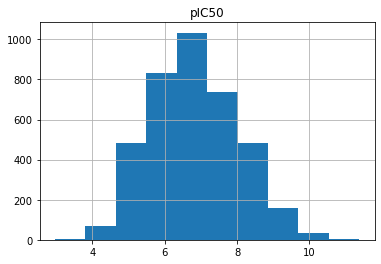

In [104]:
output_df.hist(column="pIC50")

In the next steps, we add a column for RDKit molecule objects to our `DataFrame` and look at the structures of the molecules with the highest pIC50 values. 

In [105]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [106]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

Show the three most active molecules, i.e. molecules with the highest pIC50 values.

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL2419149,0.0042,nM,11.376751,
1,CHEMBL2419144,0.0047,nM,11.327902,
2,CHEMBL1093479,0.0082,nM,11.086186,

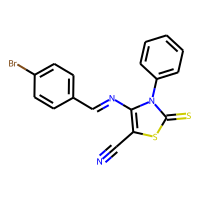
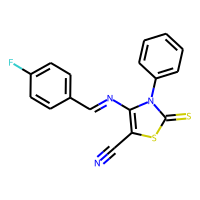
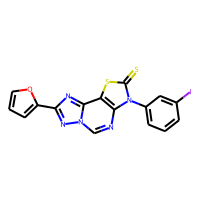

In [107]:
output_df.drop("smiles", axis=1).head(3)

In [108]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (3838, 5)


#### Write output data to file

We want to use this bioactivity-compound dataset in the following talktorials, thus we save the data as `csv` file. 
Note that it is advisable to drop the molecule column (which only contains an image of the molecules) when saving the data.

In [109]:
output_df.to_csv(DATA / "A2A_compounds.csv")
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL2419149,0.0042,nM,N#Cc1sc(=S)n(-c2ccccc2)c1/N=C/c1ccc(Br)cc1,11.376751
1,CHEMBL2419144,0.0047,nM,N#Cc1sc(=S)n(-c2ccccc2)c1/N=C/c1ccc(F)cc1,11.327902
2,CHEMBL1093479,0.0082,nM,S=c1sc2c(ncn3nc(-c4ccco4)nc23)n1-c1cccc(I)c1,11.086186
3,CHEMBL2419139,0.0100,nM,CCn1c(/N=C/c2ccc(Br)cc2)c(C#N)sc1=S,11.000000
4,CHEMBL1092271,0.0160,nM,C=CCn1c(=S)sc2c1ncn1nc(-c3ccco3)nc21,10.795880


In [110]:
print(f"DataFrame shape: {output_df.shape}")
# NBVAL_CHECK_OUTPUT

DataFrame shape: (3838, 5)


## Discussion

In this tutorial, we collected bioactivity data for our target of interest from the ChEMBL database. 
We filtered the data set in order to only contain molecules with measured IC50 bioactivity values. 

Be aware that ChEMBL data originates from various sources. Compound data has been generated in different labs by different people all over the world. Therefore, we have to be cautious with the predictions we make using this data set. It is always important to consider the source of the data and consistency of data production assays when interpreting the results and determining how much confidence we have in our predictions.

In the next tutorials, we will filter our acquired data by Lipinski's rule of five and by unwanted substructures. Another important step would be to *clean* the molecular data. As this is not shown in any of our talktorials (yet), we would like to refer to the [Standardiser library](https://github.com/flatkinson/standardiser) or [MolVS](https://molvs.readthedocs.io/en/latest/) as useful tools for this task.

## Quiz

* We have downloaded in this talktorial molecules and bioactivity data from ChEMBL. What else is the ChEMBL database useful for?
* What is the difference between IC50 and EC50?
* What can we use the data extracted from ChEMBL for?